In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import random
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.cross_validation import train_test_split

from scipy.ndimage.measurements import label

%matplotlib inline

/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Read in picture data
vehicle_images_location = glob.glob('/data/vehicles/*/*.png')
non_vehicle_images_location = glob.glob('/data/non-vehicles/*/*.png')

vehicles = []
non_vehicles = []

for path in vehicle_images_location:
    image = mpimg.imread(path)
    vehicles.append(image)

for path in non_vehicle_images_location:
    image = mpimg.imread(path)
    non_vehicles.append(image)

Vehicle training set image count: 8792
Non-vehicle training set image count: 8968


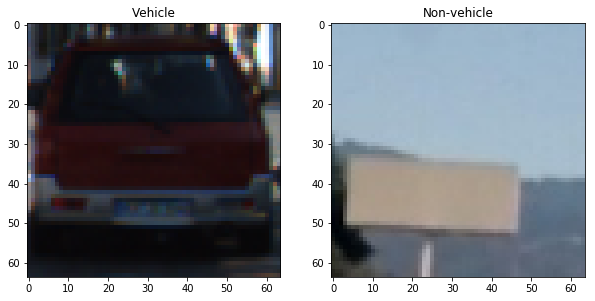

In [3]:
veh_len = len(vehicle_images_location)
nonveh_len = len(non_vehicle_images_location)

print('Vehicle training set image count: {}'.format(len(vehicles)))
print('Non-vehicle training set image count: {}'.format(len(non_vehicles)))

idx = random.randint(1, len(vehicles))

veh = vehicles[idx]
nonveh = non_vehicles[idx]

fig, axs = plt.subplots(ncols = 2, figsize = (10,10))
axs[0].imshow(veh)
axs[0].set_title('Vehicle')
axs[1].imshow(nonveh)
axs[1].set_title('Non-vehicle')
fig.savefig('./output_images/veh_nonveh_example.jpg')

In [4]:
# Code from lesson materials
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=True, 
                     feature_vec=True):
                         
    if vis == True:
        hog_features, hog_image = hog(img, orientations=orient,
                          pixels_per_cell=(pix_per_cell, pix_per_cell), 
                          cells_per_block=(cell_per_block, cell_per_block), 
                          visualise=vis, feature_vector=feature_vec,
                          block_norm="L2-Hys")
        return hog_features, hog_image
    else:
        hog_features = hog(img, orientations=orient,
                          pixels_per_cell=(pix_per_cell, pix_per_cell), 
                          cells_per_block=(cell_per_block, cell_per_block), 
                          visualise=vis, feature_vector=feature_vec,
                          block_norm="L2-Hys")
        return hog_features

In [5]:
# Code based on lesson material
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(images, color_space='RGB', spatial_size=(32, 32), 
                     hist_bins=32, orient=9, pix_per_cell=8,
                     cell_per_block=2, hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in tqdm(images):
        file_features = []
        img = mpimg.imread(file) # idea for the progress came from "nhiddink"
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(img)
            
        if spatial_feat == True:
            # Apply bin_spatial() to get spatial color features
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist() also with a color space option now
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
            # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                                                pix_per_cell, cell_per_block, vis=False,
                                                feature_vec=True)
            file_features.append(hog_features)
        # Append the new feature vector to the features list
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [6]:
# Extract features, define label vector, shuffle and split
#colorspace = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
#orient = 9
#pix_per_cell = 16
#cell_per_block = 4

#colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
#orient1 = 10
#pix_per_cell1 = 16
#cell_per_block1 = 2
#hog_channel1 = 'ALL' # Can be 0, 1, 2, or "ALL"
#sp_size = (16,16)
#h_bins = 64


colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient1 = 14
pix_per_cell1 = 16
cell_per_block1 = 4
hog_channel1 = 'ALL' # Can be 0, 1, 2, or "ALL"
sp_size = (16, 16)
h_bins = 32

t=time.time()
#vehicle_images_location, non_vehicle_images_location
car_features = extract_features(vehicle_images_location, color_space=colorspace, spatial_size=sp_size,
                                hist_bins=h_bins, orient=orient1, pix_per_cell=pix_per_cell1,
                                cell_per_block=cell_per_block1, hog_channel=hog_channel1,
                                spatial_feat=True, hist_feat=True, hog_feat=True)
notcar_features = extract_features(non_vehicle_images_location, color_space=colorspace, spatial_size=sp_size,
                                hist_bins=h_bins, orient=orient1, pix_per_cell=pix_per_cell1,
                                cell_per_block=cell_per_block1, hog_channel=hog_channel1,
                                spatial_feat=True, hist_feat=True, hog_feat=True)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract features...')

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient1,'orientations',pix_per_cell1,
    'pixels per cell and', cell_per_block1,'cells per block')
print('Feature vector length:', len(X_train[0]))

100%|██████████| 8968/8968 [00:43<00:00, 199.20it/s]


88.31 Seconds to extract features...
Using: 14 orientations 16 pixels per cell and 4 cells per block
Feature vector length: 1536


In [7]:
# Train Classifier
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

4.53 Seconds to train SVC...
Test Accuracy of SVC =  0.9803
My SVC predicts:  [ 0.  1.  0.  0.  1.  0.  1.  0.  0.  0.]
For these 10 labels:  [ 0.  1.  0.  0.  1.  0.  1.  0.  0.  0.]
0.00252 Seconds to predict 10 labels with SVC


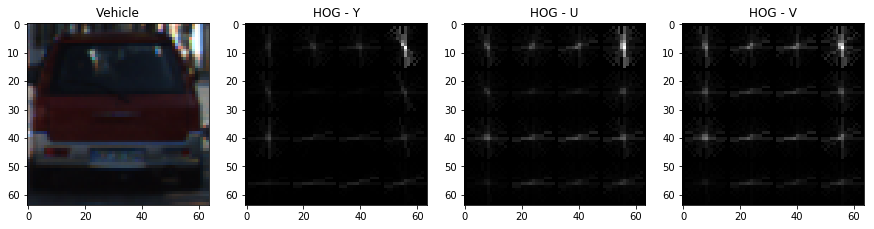

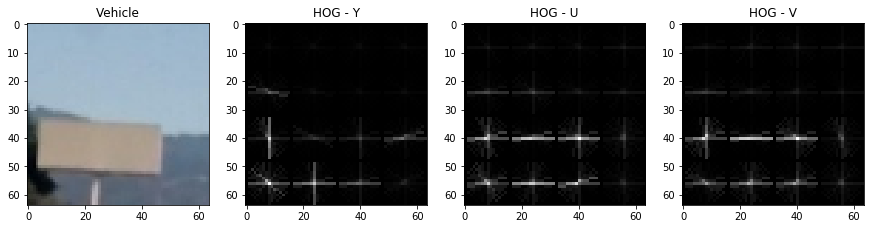

In [8]:
# Hog images with selected parameters
veh_yuv    = cv2.cvtColor(veh, cv2.COLOR_RGB2YUV)
nonveh_yuv = cv2.cvtColor(nonveh, cv2.COLOR_RGB2YUV)
_, car_hog_y = get_hog_features(veh_yuv[:,:,0], orient1, 
                        pix_per_cell1, cell_per_block1, 
                        vis=True, feature_vec=False)
_, car_hog_u = get_hog_features(veh_yuv[:,:,1], orient1, 
                        pix_per_cell1, cell_per_block1, 
                        vis=True, feature_vec=False)
_, car_hog_v = get_hog_features(veh_yuv[:,:,2], orient1, 
                        pix_per_cell1, cell_per_block1, 
                        vis=True, feature_vec=False)

_, noncar_hog_y = get_hog_features(nonveh_yuv[:,:,0], orient1, 
                        pix_per_cell1, cell_per_block1, 
                        vis=True, feature_vec=False)
_, noncar_hog_u = get_hog_features(nonveh_yuv[:,:,1], orient1, 
                        pix_per_cell1, cell_per_block1, 
                        vis=True, feature_vec=False)
_, noncar_hog_v = get_hog_features(nonveh_yuv[:,:,2], orient1, 
                        pix_per_cell1, cell_per_block1, 
                        vis=True, feature_vec=False)
# Visualize 
fig, axes = plt.subplots(ncols=4, figsize=(15,15))
axes[0].imshow(veh)
axes[0].set_title('Vehicle')
axes[1].imshow(car_hog_y, cmap='gray')
axes[1].set_title('HOG - Y')
axes[2].imshow(car_hog_u, cmap='gray')
axes[2].set_title('HOG - U')
axes[3].imshow(car_hog_v, cmap='gray')
axes[3].set_title('HOG - V')
fig.savefig('./output_images/veh_HOG_example.jpg')

# Visualize 
fig1, axes1 = plt.subplots(ncols=4, figsize=(15,15))
axes1[0].imshow(nonveh)
axes1[0].set_title('Vehicle')
axes1[1].imshow(noncar_hog_y, cmap='gray')
axes1[1].set_title('HOG - Y')
axes1[2].imshow(noncar_hog_u, cmap='gray')
axes1[2].set_title('HOG - U')
axes1[3].imshow(noncar_hog_v, cmap='gray')
axes1[3].set_title('HOG - V')
fig1.savefig('./output_images/nonveh_HOG_example.jpg')

In [9]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, X_scaler, scale, svc, cspace, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,
             hog_channel = 'ALL', show_all=False):
    
    rects = []
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(img_tosearch)   
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            #Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            #test_features = X_scaler.transform((hog_features).reshape(1, -1))    

            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1 or show_all:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                rects.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    #return draw_img
    return rects

In [10]:
# Draw boxes function from lesson material
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

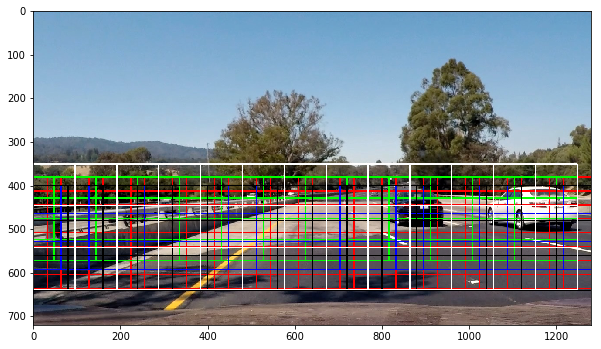

In [11]:
# Draw rectangles on example image
test_image = mpimg.imread('./test_images/test4.jpg')
#test_image = mpimg.imread('./test_images/test1.jpg')

rect1 = []
rect2 = []
rect3 = []
rect4 = []
rect5 = []

#x_start = 0
#x_stop = 1280
orient1 = 14
pix_per_cell1 = 16
cell_per_block1 = 4
hog_channel1 = 'ALL' # Can be 0, 1, 2, or "ALL"
sp_size = (16, 16)
h_bins = 32

#scale = 0.75
#y_start = 380 # Min and max in y to search in slide_window()
#y_stop = 650
#rect1.append(find_cars(test_image, y_start, y_stop, X_scaler, scale, svc, colorspace, orient1, pix_per_cell1, cell_per_block1, sp_size, h_bins))


scale = 1.0
y_start = 380 # Min and max in y to search in slide_window()
y_stop = 650
rect1.append(find_cars(test_image, y_start, y_stop, X_scaler, scale, svc, colorspace, orient1, pix_per_cell1,
                       cell_per_block1, sp_size, h_bins, hog_channel = 'ALL', show_all=True ))

rectangles1 = [item for sublist in rect1 for item in sublist] 


y_start = 380 # Min and max in y to search in slide_window()
y_stop = 600
scale = 1.5
rect2.append(find_cars(test_image, y_start, y_stop, X_scaler, scale, svc, colorspace, orient1, pix_per_cell1,
                       cell_per_block1, sp_size, h_bins, hog_channel = 'ALL', show_all=True ))
rectangles2 = [item for sublist in rect2 for item in sublist] 

y_start = 400 # Min and max in y to search in slide_window()
y_stop = 650
scale = 2.0
rect3.append(find_cars(test_image, y_start, y_stop, X_scaler, scale, svc, colorspace, orient1, pix_per_cell1, 
                       cell_per_block1, sp_size, h_bins, hog_channel = 'ALL', show_all=True ))
rectangles3 = [item for sublist in rect3 for item in sublist] 

y_start = 400 # Min and max in y to search in slide_window()
y_stop = 660
scale = 2.5
rect4.append(find_cars(test_image, y_start, y_stop, X_scaler, scale, svc, colorspace, orient1, pix_per_cell1, 
                       cell_per_block1, sp_size, h_bins, hog_channel = 'ALL', show_all=True ))
rectangles4 = [item for sublist in rect4 for item in sublist] 

y_start = 350 # Min and max in y to search in slide_window()
y_stop = 680
scale = 3.0
rect5.append(find_cars(test_image, y_start, y_stop, X_scaler, scale, svc, colorspace, orient1, pix_per_cell1, 
                       cell_per_block1, sp_size, h_bins, hog_channel = 'ALL', show_all=True ))
rectangles5 = [item for sublist in rect5 for item in sublist] 


test_img_rects = draw_boxes(test_image, rectangles1, color=[256, 0, 0], thick=2)
test_img_rects = draw_boxes(test_img_rects, rectangles2, color=[0, 256, 0], thick=2)
test_img_rects = draw_boxes(test_img_rects, rectangles3, color=[0, 0, 256], thick=2)
test_img_rects = draw_boxes(test_img_rects, rectangles4, color=[0, 0, 0], thick=2)
test_img_rects = draw_boxes(test_img_rects, rectangles5, color=[256, 256, 256], thick=2)


plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
plt.savefig('./output_images/test4_all_boxes.jpg')

In [12]:
# Draw rectangles on example image
test_image = mpimg.imread('./test_images/test4.jpg')
#test_image = mpimg.imread('./test_images/test1.jpg')

rect1 = []

#x_start = 0
#x_stop = 1280
orient1 = 14
pix_per_cell1 =16
cell_per_block1 = 4
hog_channel1 = 'ALL' # Can be 0, 1, 2, or "ALL"
sp_size = (16, 16)
h_bins = 32

#scale = 0.75
#y_start = 380 # Min and max in y to search in slide_window()
#y_stop = 650
#rect1.append(find_cars(test_image, y_start, y_stop, X_scaler, scale, svc, colorspace, orient1, pix_per_cell1, cell_per_block1, sp_size, h_bins))


scale = 1.0
y_start = 380 # Min and max in y to search in slide_window()
y_stop = 650
rect1.append(find_cars(test_image, y_start, y_stop, X_scaler, scale, svc, colorspace, orient1, pix_per_cell1,
                       cell_per_block1, sp_size, h_bins, hog_channel1, show_all=False ))

y_start = 380 # Min and max in y to search in slide_window()
y_stop = 600
scale = 1.5
rect1.append(find_cars(test_image, y_start, y_stop, X_scaler, scale, svc, colorspace, orient1, pix_per_cell1,
                       cell_per_block1, sp_size, h_bins, hog_channel1, show_all=False ))

y_start = 400 # Min and max in y to search in slide_window()
y_stop = 650
scale = 2.0
rect1.append(find_cars(test_image, y_start, y_stop, X_scaler, scale, svc, colorspace, orient1, pix_per_cell1, 
                       cell_per_block1, sp_size, h_bins, hog_channel1, show_all=False ))

y_start = 400 # Min and max in y to search in slide_window()
y_stop = 660
scale = 2.5
rect1.append(find_cars(test_image, y_start, y_stop, X_scaler, scale, svc, colorspace, orient1, pix_per_cell1, 
                       cell_per_block1, sp_size, h_bins, hog_channel1, show_all=False ))

y_start = 350 # Min and max in y to search in slide_window()
y_stop = 680
scale = 3.0
rect1.append(find_cars(test_image, y_start, y_stop, X_scaler, scale, svc, colorspace, orient1, pix_per_cell1, 
                       cell_per_block1, sp_size, h_bins, hog_channel1, show_all=False ))

rectangles = [item for sublist in rect1 for item in sublist] 

print(len(rectangles), 'rectangles found in image')

27 rectangles found in image


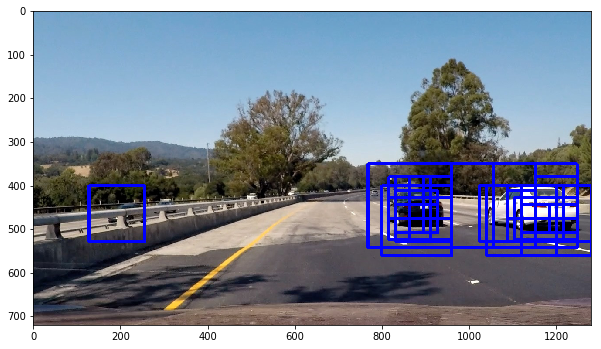

In [13]:
test_rects = draw_boxes(test_image, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(test_rects)
plt.savefig('./output_images/test4_boxes_raw.jpg')
#print(rectangles)
#print(rectangles[0][1][0])

In [14]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
        
        #if ((box[0][0] > 600)  ):
        #    heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1           
    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

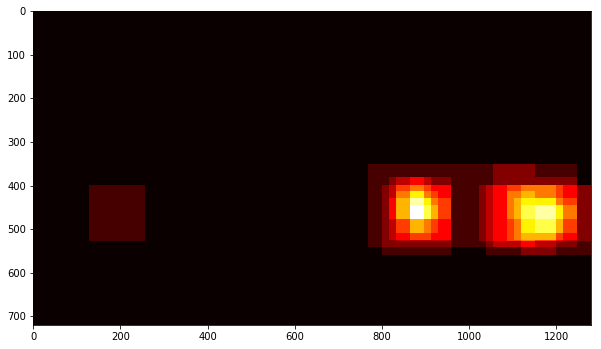

In [15]:
# Test heatmap
heatmap01 = np.zeros_like(test_image[:,:,0])
heatmap01 = add_heat(heatmap01, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(heatmap01, cmap='hot')
plt.savefig('./output_images/test4_heat_box.jpg')

In [16]:
#function to threshold the heat map

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

2 cars found


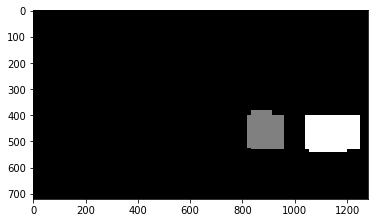

In [17]:
heatmap02 = apply_threshold(heatmap01, 2.0)
labels = label(heatmap02)
print(labels[1], 'cars found')
plt.imshow(labels[0], cmap='gray')
plt.savefig('./output_images/test4_thresholded.jpg')

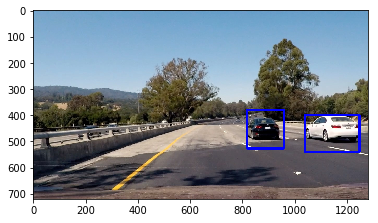

In [18]:
# Code to draw boxes around labeled regions from lesson material
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 7)
    # Return the image
    return img


# Draw bounding boxes on a copy of the image
draw_img = draw_labeled_bboxes(np.copy(test_image), labels)
# Display the image
plt.imshow(draw_img)
plt.savefig('./output_images/test4_boxes_processed.jpg')

#print(labels)

In [25]:
# Pipeline

def frame_pipeline(img):
    rect1 = []
    
    
    #x_start = 0
    #x_stop = 1280
    colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient1 = 14
    pix_per_cell1 = 16
    cell_per_block1 = 4
    hog_channel1 = 'ALL' # Can be 0, 1, 2, or "ALL"
    sp_size = (16, 16)
    h_bins = 32
    
    #scale = 0.75
    #y_start = 380 # Min and max in y to search in slide_window()
    #y_stop = 450
    #rect1.append(find_cars(img, y_start, y_stop, X_scaler, scale, svc, colorspace, orient1, pix_per_cell1, cell_per_block1, sp_size, h_bins))
    
    
    scale = 1.0
    y_start = 380 # Min and max in y to search in slide_window()
    y_stop = 550
    rect1.append(find_cars(img, y_start, y_stop, X_scaler, scale, svc, colorspace, orient1, pix_per_cell1, cell_per_block1, 
                           sp_size, h_bins, hog_channel1, show_all=False ))
    
    y_start = 380 # Min and max in y to search in slide_window()
    y_stop = 600
    scale = 1.5
    rect1.append(find_cars(img, y_start, y_stop, X_scaler, scale, svc, colorspace, orient1, pix_per_cell1, cell_per_block1, 
                           sp_size, h_bins, hog_channel1, show_all=False ))
    
    y_start = 400 # Min and max in y to search in slide_window()
    y_stop = 650  
    scale = 2.0
    rect1.append(find_cars(img, y_start, y_stop, X_scaler, scale, svc, colorspace, orient1, pix_per_cell1, cell_per_block1, 
                           sp_size, h_bins, hog_channel1, show_all=False ))

    y_start = 400 # Min and max in y to search in slide_window()
    y_stop = 660  
    scale = 2.5
    rect1.append(find_cars(img, y_start, y_stop, X_scaler, scale, svc, colorspace, orient1, pix_per_cell1, cell_per_block1, 
                           sp_size, h_bins, hog_channel1, show_all=False ))

    y_start = 350 # Min and max in y to search in slide_window()
    y_stop = 680
    scale = 3.0
    rect1.append(find_cars(test_image, y_start, y_stop, X_scaler, scale, svc, colorspace, orient1, pix_per_cell1, 
                       cell_per_block1, sp_size, h_bins, hog_channel1, show_all=False ))   
    rectangles = [item for sublist in rect1 for item in sublist] 
    
    heatmap01 = np.zeros_like(img[:,:,0])
    heatmap01 = add_heat(heatmap01, rectangles)
    heatmap02 = apply_threshold(heatmap01, 3.0)
    labels = label(heatmap02)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

In [26]:
test_img_paths = glob.glob('./test_images/test*.jpg')

test_imgs = []
test_imgs_output = []

for idx, path in enumerate(test_img_paths):
    test_imgs.append(mpimg.imread(path))
    test_imgs_output.append(frame_pipeline(test_imgs[idx]))

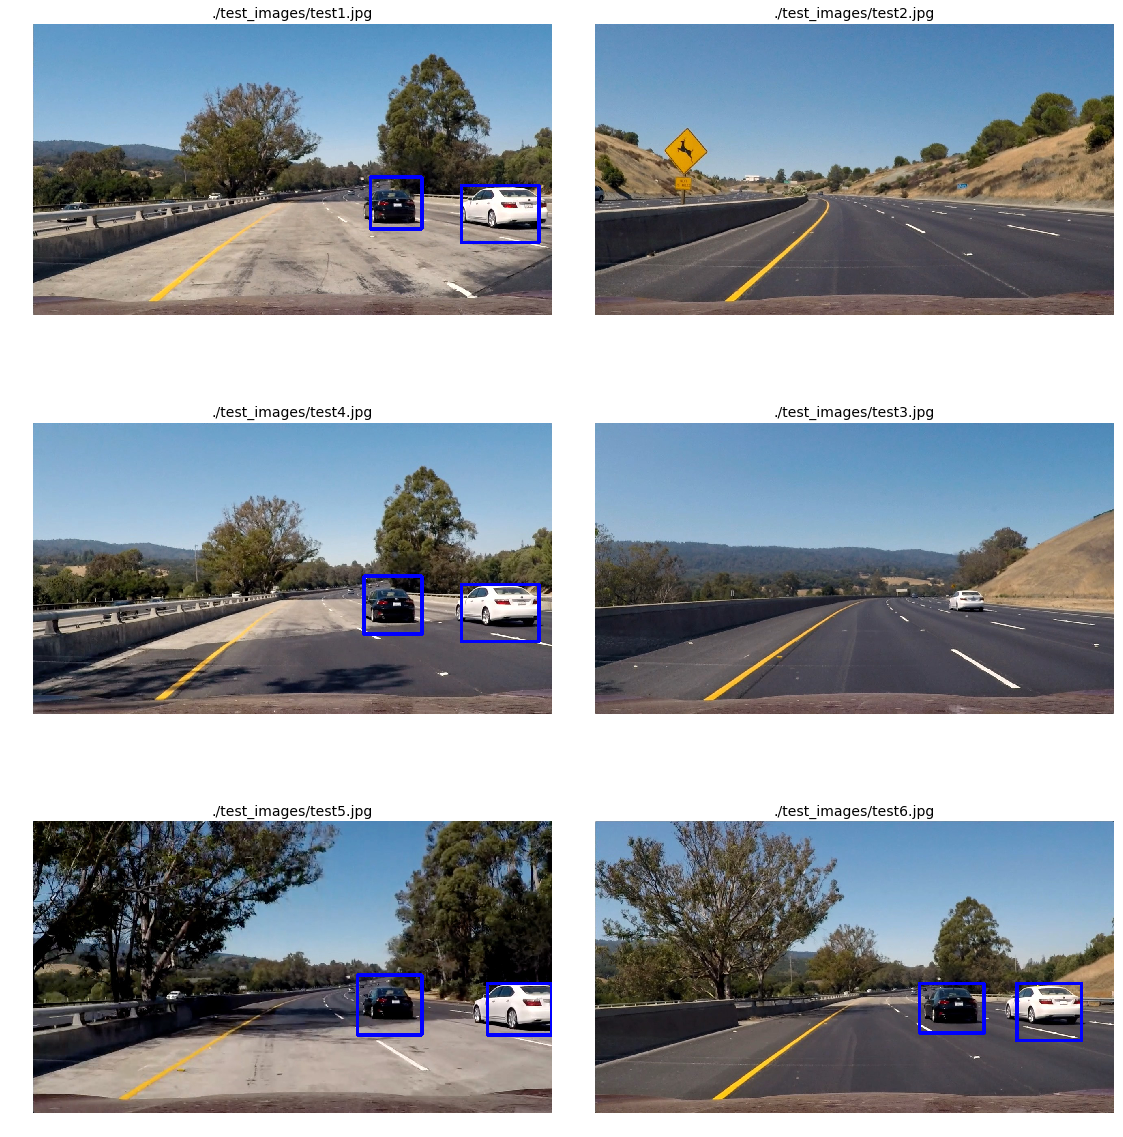

In [27]:
f1, ax1 = plt.subplots(3, 2, figsize=(15, 18))
f1.tight_layout()
for ax2, idx in zip(ax1.flat, range(6)):
    ax2.imshow(test_imgs_output[idx])
    ax2.set_title(test_img_paths[idx], fontsize=14)
    ax2.axis('off')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
f1.savefig('./output_images/frame_pipeline_output.jpg')

In [28]:
from moviepy.editor import VideoFileClip

test_out_file = 'test_out_frame.mp4'
clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(frame_pipeline)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video test_out_frame.mp4
[MoviePy] Writing video test_out_frame.mp4


 97%|█████████▋| 38/39 [00:26<00:00,  1.46it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_out_frame.mp4 

CPU times: user 23 s, sys: 2.27 s, total: 25.3 s
Wall time: 29.5 s


In [29]:
test_out_file = 'project_out_frame3.mp4'
clip_test = VideoFileClip('project_video.mp4')
clip_test_out = clip_test.fl_image(frame_pipeline)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video project_out_frame3.mp4
[MoviePy] Writing video project_out_frame3.mp4


100%|█████████▉| 1260/1261 [15:36<00:00,  1.33it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_out_frame3.mp4 

CPU times: user 12min 35s, sys: 53.1 s, total: 13min 28s
Wall time: 15min 39s


In [34]:
# Define a class to store data from video
class detect_vehicle():
    def __init__(self):
        # history of rectangles previous n frames
        self.prev_rects = [] 
        
    def add_rects(self, rects):
        self.prev_rects.append(rects)
        if len(self.prev_rects) > 15:
            # throw out oldest rectangle set(s)
            self.prev_rects = self.prev_rects[len(self.prev_rects)-15:]

In [43]:
def video_pipeline(img):
    rect1 = []
    
    
    #x_start = 0
    #x_stop = 1280
    colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient1 = 14
    pix_per_cell1 = 16
    cell_per_block1 = 4
    hog_channel1 = 'ALL' # Can be 0, 1, 2, or "ALL"
    sp_size = (16, 16)
    h_bins = 32
    
    #scale = 0.75
    #y_start = 380 # Min and max in y to search in slide_window()
    #y_stop = 450
    #rect1.append(find_cars(img, y_start, y_stop, X_scaler, scale, svc, colorspace, orient1, pix_per_cell1, cell_per_block1, sp_size, h_bins))
    
    
    scale = 1.0
    y_start = 380 # Min and max in y to search in slide_window()
    y_stop = 550
    rect1.append(find_cars(img, y_start, y_stop, X_scaler, scale, svc, colorspace, orient1, pix_per_cell1, cell_per_block1, 
                           sp_size, h_bins, hog_channel1, show_all=False ))
    
    y_start = 380 # Min and max in y to search in slide_window()
    y_stop = 600
    scale = 1.5
    rect1.append(find_cars(img, y_start, y_stop, X_scaler, scale, svc, colorspace, orient1, pix_per_cell1, cell_per_block1, 
                           sp_size, h_bins, hog_channel1, show_all=False ))
    
    y_start = 400 # Min and max in y to search in slide_window()
    y_stop = 650  
    scale = 2.0
    rect1.append(find_cars(img, y_start, y_stop, X_scaler, scale, svc, colorspace, orient1, pix_per_cell1, cell_per_block1, 
                           sp_size, h_bins, hog_channel1, show_all=False ))

    y_start = 400 # Min and max in y to search in slide_window()
    y_stop = 660  
    scale = 2.5
    rect1.append(find_cars(img, y_start, y_stop, X_scaler, scale, svc, colorspace, orient1, pix_per_cell1, cell_per_block1, 
                           sp_size, h_bins, hog_channel1, show_all=False ))

    y_start = 350 # Min and max in y to search in slide_window()
    y_stop = 680
    scale = 3.0
    rect1.append(find_cars(test_image, y_start, y_stop, X_scaler, scale, svc, colorspace, orient1, pix_per_cell1, 
                       cell_per_block1, sp_size, h_bins, hog_channel1, show_all=False ))   
    rectangles = [item for sublist in rect1 for item in sublist] 
    
     # add detections to the history
    if len(rectangles) > 0:
        det.add_rects(rectangles)
    
    heatmap_img = np.zeros_like(img[:,:,0])
    for rect_set in det.prev_rects:
        heatmap_img = add_heat(heatmap_img, rect_set)
    
    ##heatmap_img = apply_threshold(heatmap_img, 20.0 + len(det.prev_rects)//1.2)
    heatmap_img = apply_threshold(heatmap_img, 38.0)
    
    labels = label(heatmap_img)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)

    return draw_img

In [44]:
det = detect_vehicle()

test_out_file2 = 'test_out_smooth_3.mp4'
clip_test2 = VideoFileClip('test_video.mp4')
clip_test_out2 = clip_test2.fl_image(video_pipeline)
%time clip_test_out2.write_videofile(test_out_file2, audio=False)

[MoviePy] >>>> Building video test_out_smooth_3.mp4
[MoviePy] Writing video test_out_smooth_3.mp4


 97%|█████████▋| 38/39 [00:26<00:00,  1.45it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_out_smooth_3.mp4 

CPU times: user 22.7 s, sys: 2.53 s, total: 25.2 s
Wall time: 29.4 s


In [45]:
det = detect_vehicle()

test_out_file2 = 'project_output_smooth_3.mp4'
clip_test2 = VideoFileClip('project_video.mp4')
clip_test_out2 = clip_test2.fl_image(video_pipeline)
%time clip_test_out2.write_videofile(test_out_file2, audio=False)

[MoviePy] >>>> Building video project_output_smooth_3.mp4
[MoviePy] Writing video project_output_smooth_3.mp4


100%|█████████▉| 1260/1261 [15:58<00:00,  1.31it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output_smooth_3.mp4 

CPU times: user 12min 35s, sys: 1min 17s, total: 13min 52s
Wall time: 16min 1s
